In [1]:
#here we test all the components.

In [2]:
from logging import getLogger 
from eden.util import configure_logging
configure_logging(getLogger('root'),verbosity=1)

In [36]:
n_graphs_per_line=6

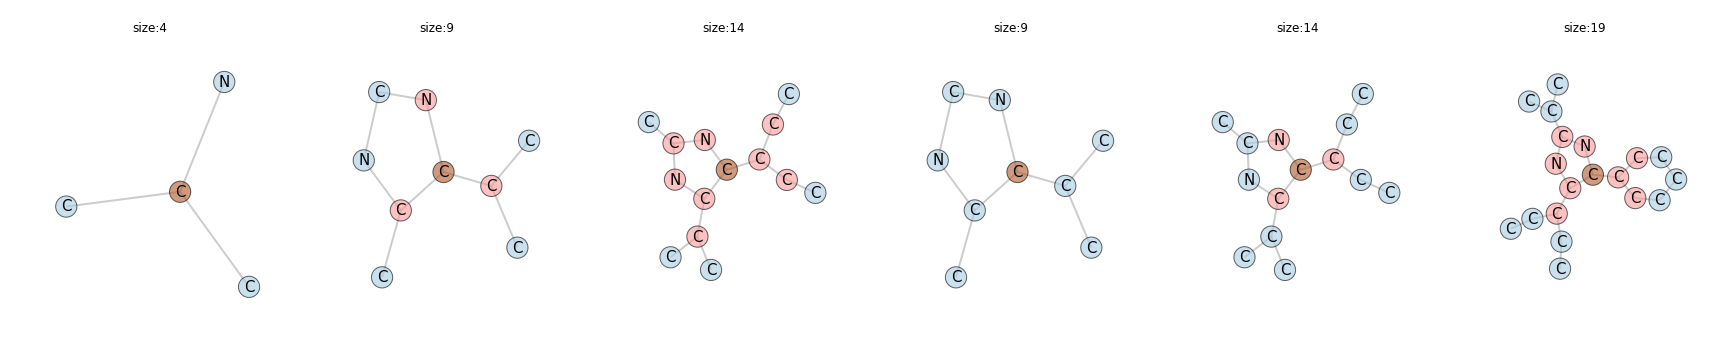

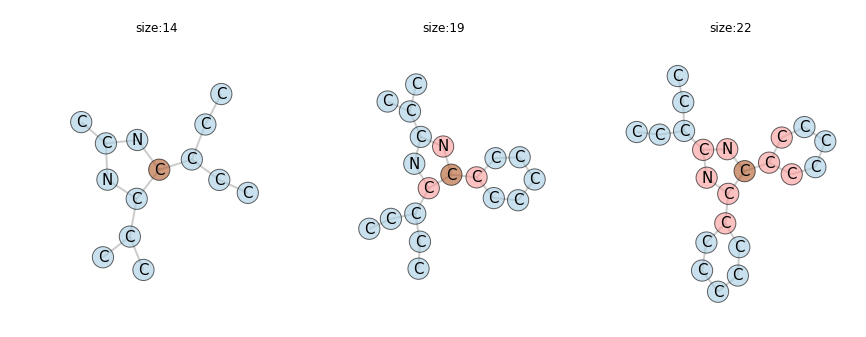

In [37]:

'''
first we test the core/interface extractor, since it is most essential
'''
import sys
sys.path.append('..')
%matplotlib inline
from eden.converter.graph.gspan import gspan_to_eden
import graphlearn.utils.draw as myutils
import graphlearn.utils.myeden as myed
import eden.graph as eg
import graphlearn.graphlearn as gl


#get a graph
gr = gspan_to_eden( 'bursi.pos.gspan' )
g=gr.next()


#lets see..
a=gl.extract_core_and_interface(1,g,radius_list=[0,1,2],thickness_list=[1,2,3],vectorizer=myed.GraphLearnVectorizer())
ng=myutils.cip_to_graph(a) 
myutils.draw_graph_set(ng, n_graphs_per_line=n_graphs_per_line, size=5, 
                       colormap='Paired', invert_colormap=False,node_border=1,
                       vertex_alpha=0.6, edge_alpha=0.2, node_size=450)

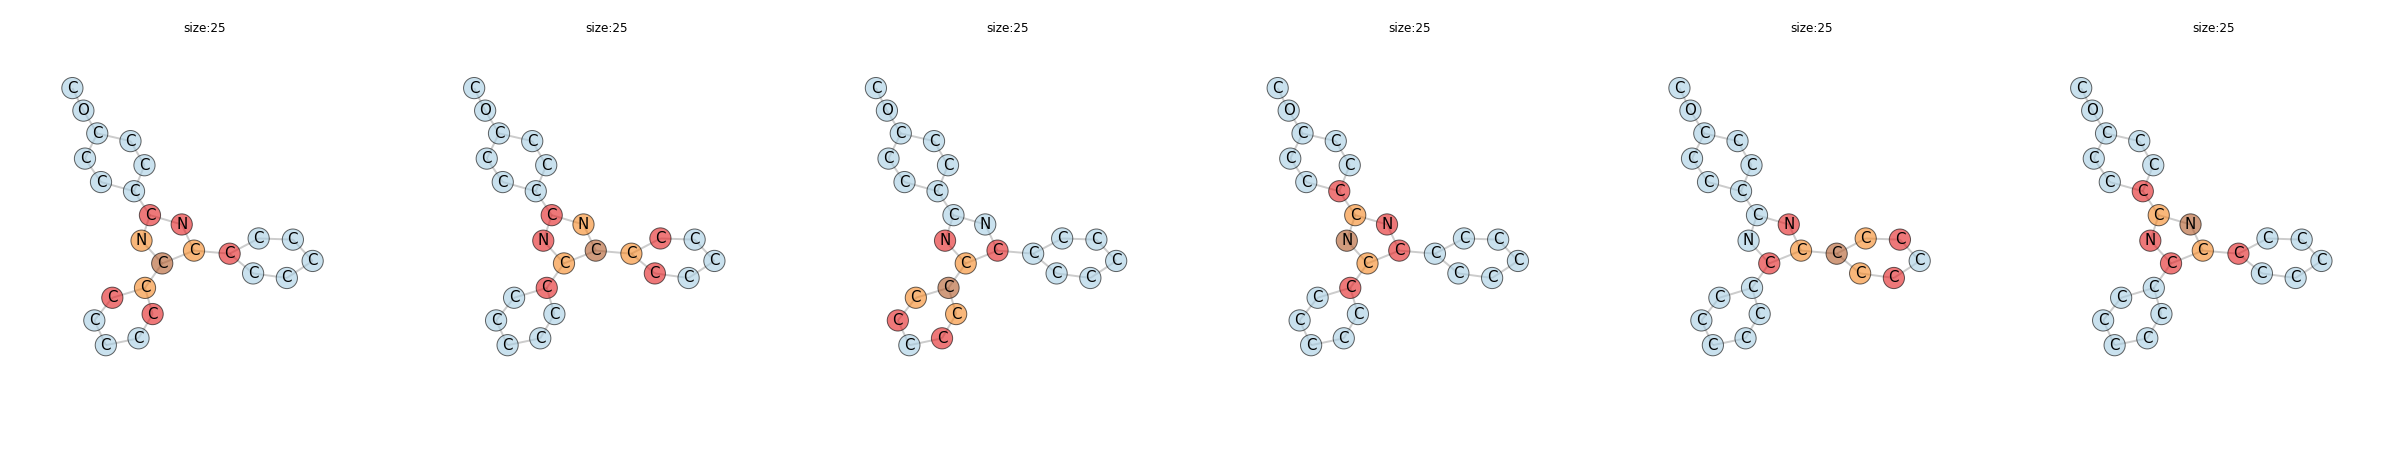

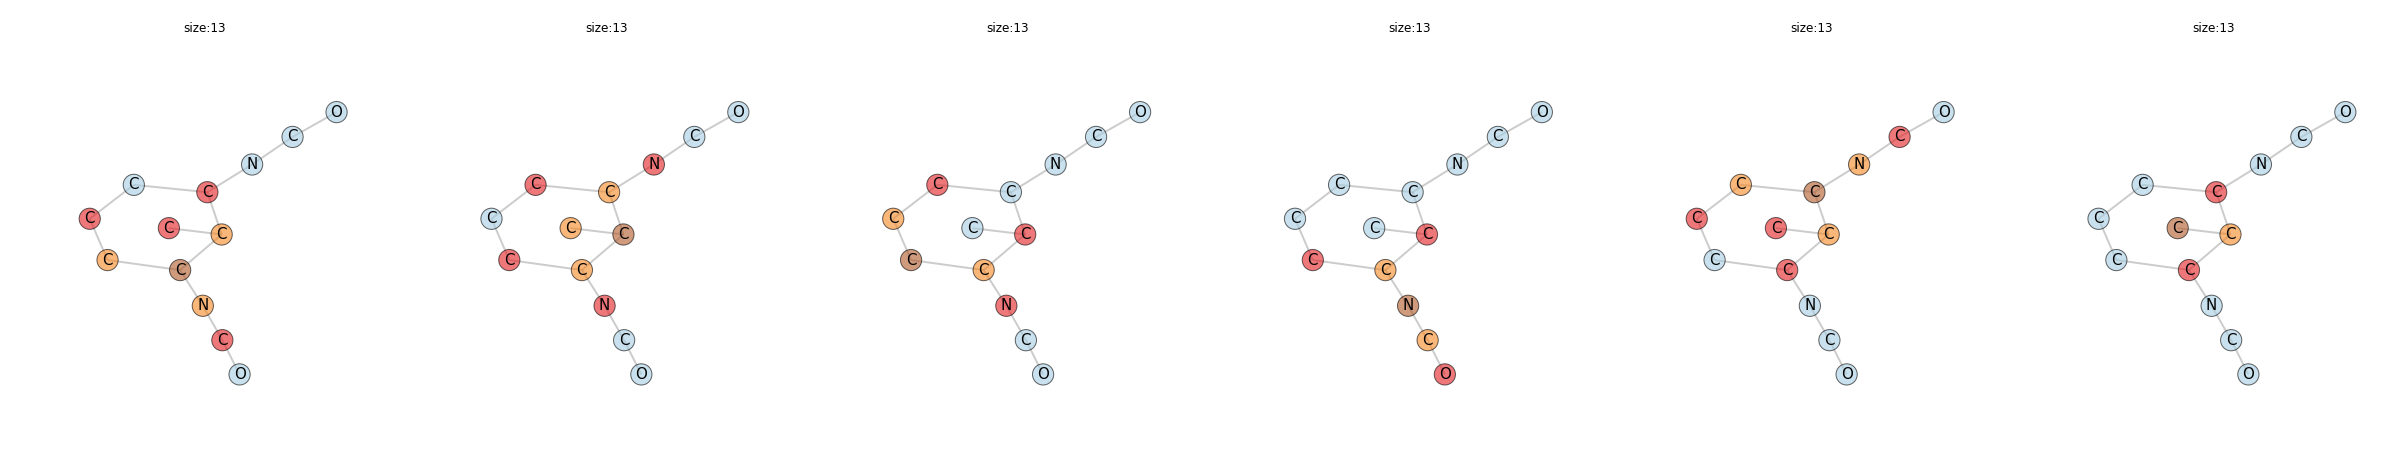

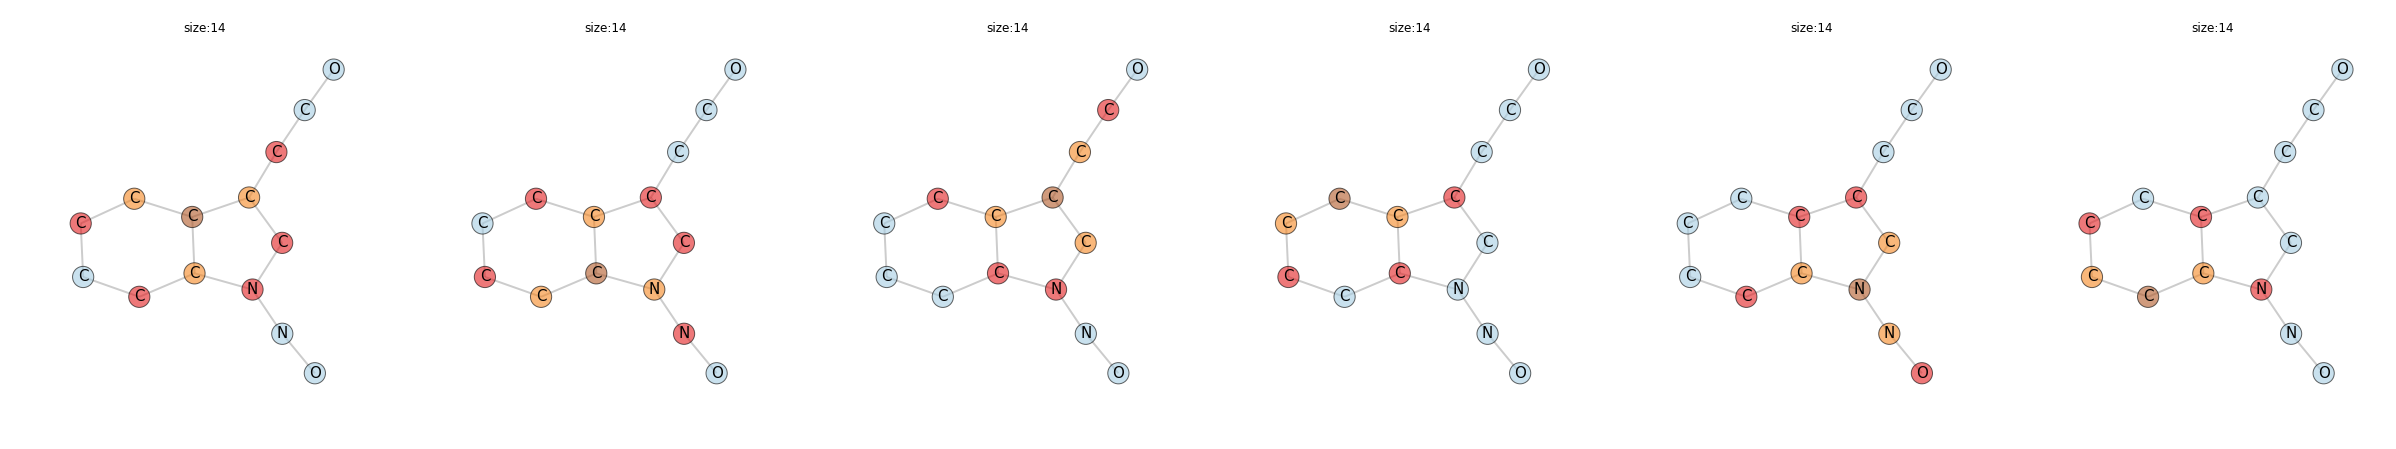

In [34]:
'''
demonstrating more extract core
'''
%matplotlib inline
import sys
sys.path.append('..')
from eden.converter.graph.gspan import gspan_to_eden
import graphlearn.utils.draw as myutils
import graphlearn.utils.myeden as myed
import eden.graph as eg
import graphlearn.graphlearn as gl


gr = gspan_to_eden( 'bursi.pos.gspan' )
num=3
for x in range (num):
    g=gr.next()
    # for each, pick 5 cores and extract cips 
    nice_graphs=[]
    for n in range(n_graphs_per_line):
        node=n
        a=gl.extract_core_and_interface(node,g,radius_list=[2],thickness_list=[1],vectorizer=myed.GraphLearnVectorizer())
        # draw cip on the original graph and save in nice_graphs
        nice_graphs+=myutils.cip_to_graph(a, graphs=[g,g]) 
        
    # draw nice_graphs
    myutils.draw_graph_set(nice_graphs, 
                           n_graphs_per_line=n_graphs_per_line, size=7, 
                           colormap='Paired', invert_colormap=False,node_border=1,
                           vertex_alpha=0.6, edge_alpha=0.2, node_size=450)

interface: 42990595


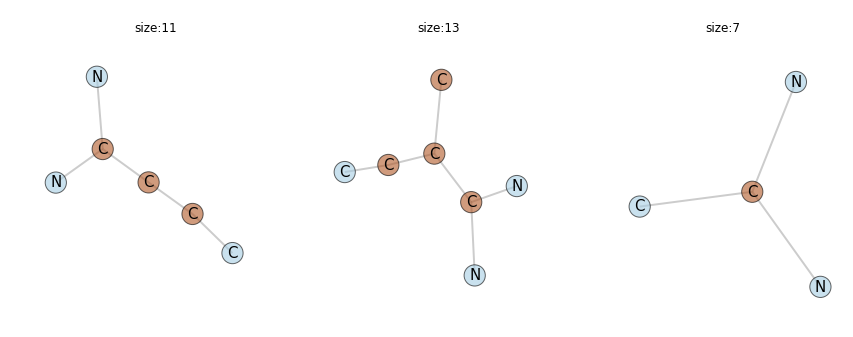

interface: 49115142


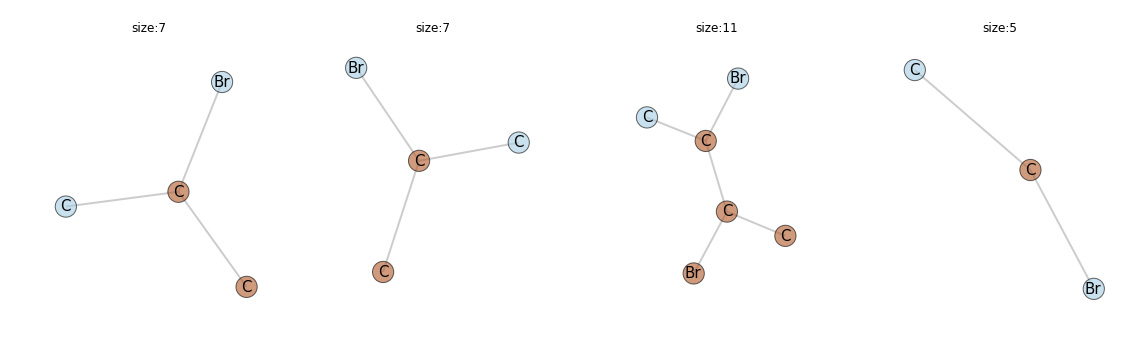

interface: 49607186


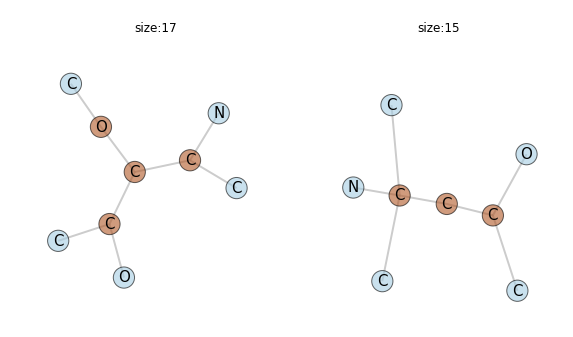

interface: 46451972


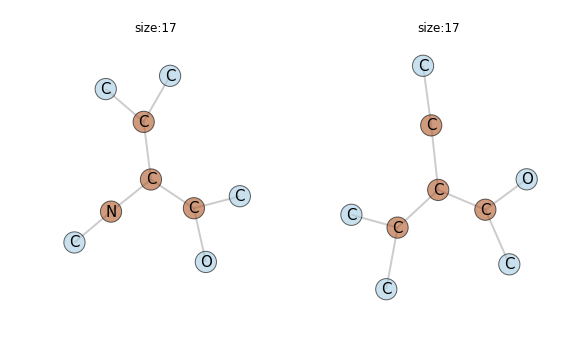

interface: 548896


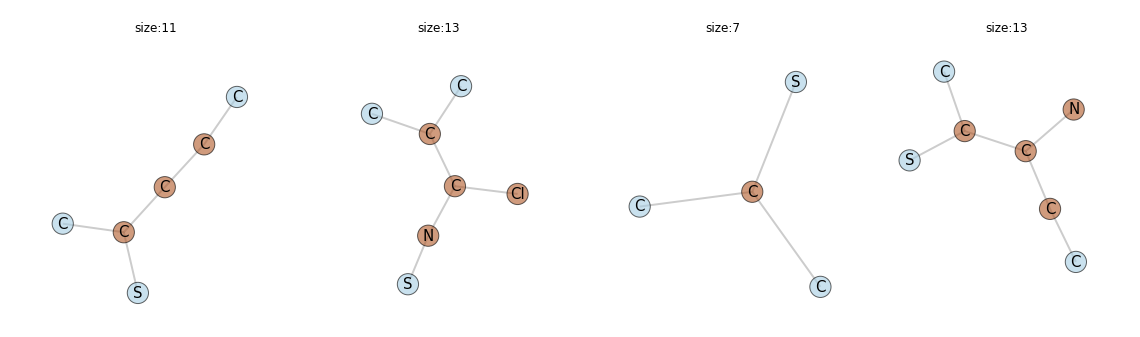

interface: 66347046


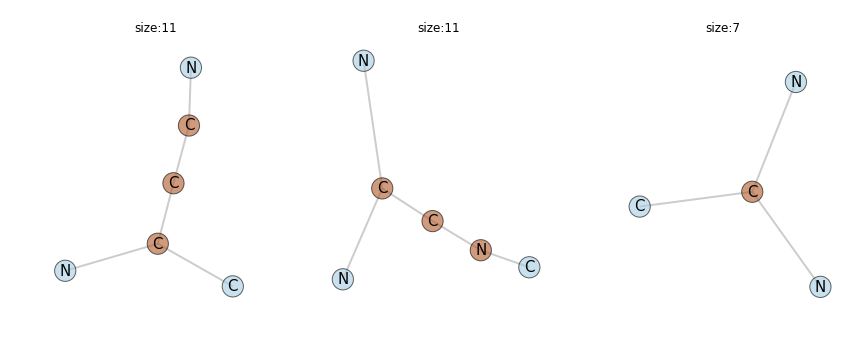

interface: 29706279


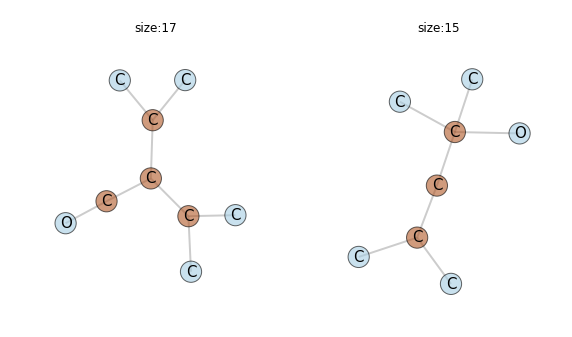

CPU times: user 9.53 s, sys: 788 ms, total: 10.3 s
Wall time: 14 s


In [48]:
%%time
'''
second is reading a grammar and training an estimator
'''
import sys
sys.path.append('..')
import os 
os.nice(20)
%matplotlib inline
import graphlearn.utils.draw as myutils
import graphlearn.graphlearn as gl
from eden.converter.graph.gspan import gspan_to_eden
import itertools
gr = gspan_to_eden( 'bursi.pos.gspan' )


# we just learn a grammar from 50 graphs..  
gr = itertools.islice(gr,200)
sampler=gl.GraphLearnSampler(radius_list=[0,1],thickness_list=[1])
#sampler=sampler.load('tmp/demo.ge')
sampler.fit(gr,n_jobs=-1)

# we look at the estimator and  draw 5 interfaces with their associated cores
#print sampler.estimator
sampler.save('tmp/demo.ge')
myutils.draw_grammar(sampler.local_substitutable_graph_grammar.grammar,n_productions=7,
                     n_graphs_per_line=n_graphs_per_line, size=5, 
                     colormap='Paired', invert_colormap=False,node_border=1,
                     vertex_alpha=0.6, edge_alpha=0.2, node_size=450)

how often do we see interfacehashes
# productions: 368
x = # interfaces (total: 73)
y=numberofcores(ihash), y=sumOfCoreCounts(ihash)


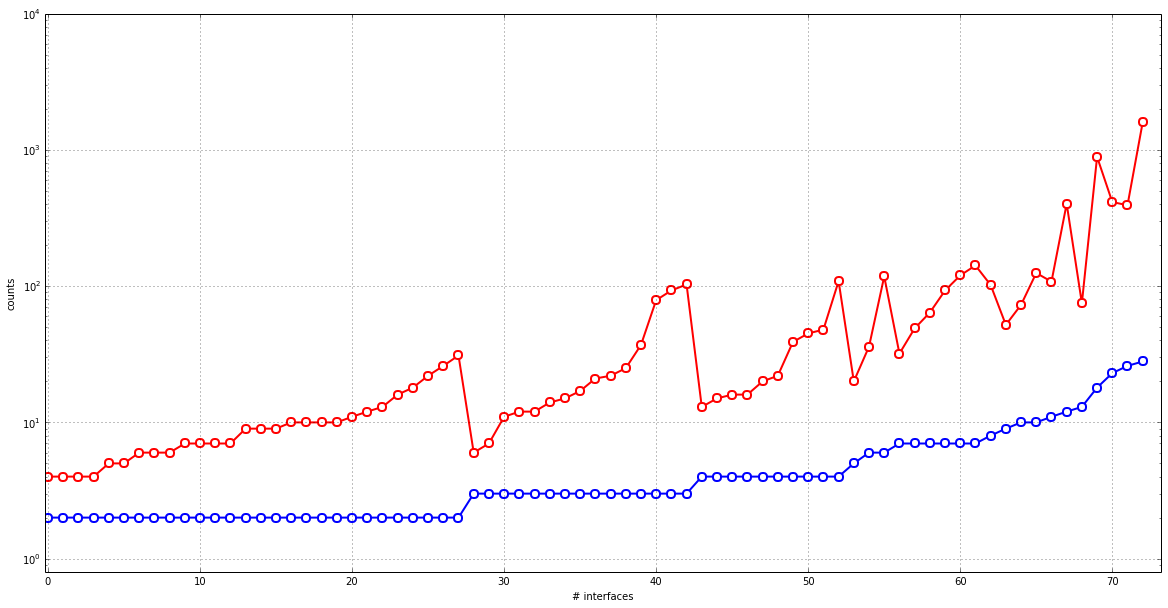

how often was this corehash seen?
x = # cores (total: 74)
y = inYinterfaces(chash), y= sumOfCountOverAllInterfaces(chash)


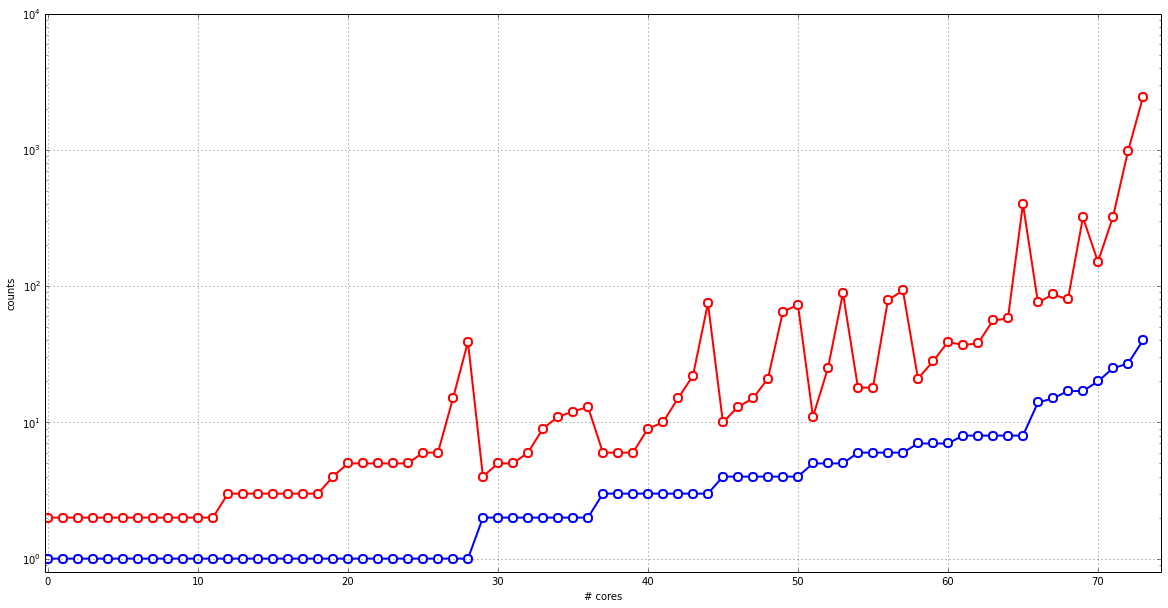

histogram
# productions: 368
distinct cores: 74 (seen on x axis)
interfaces with x many cores were observed y many times. 


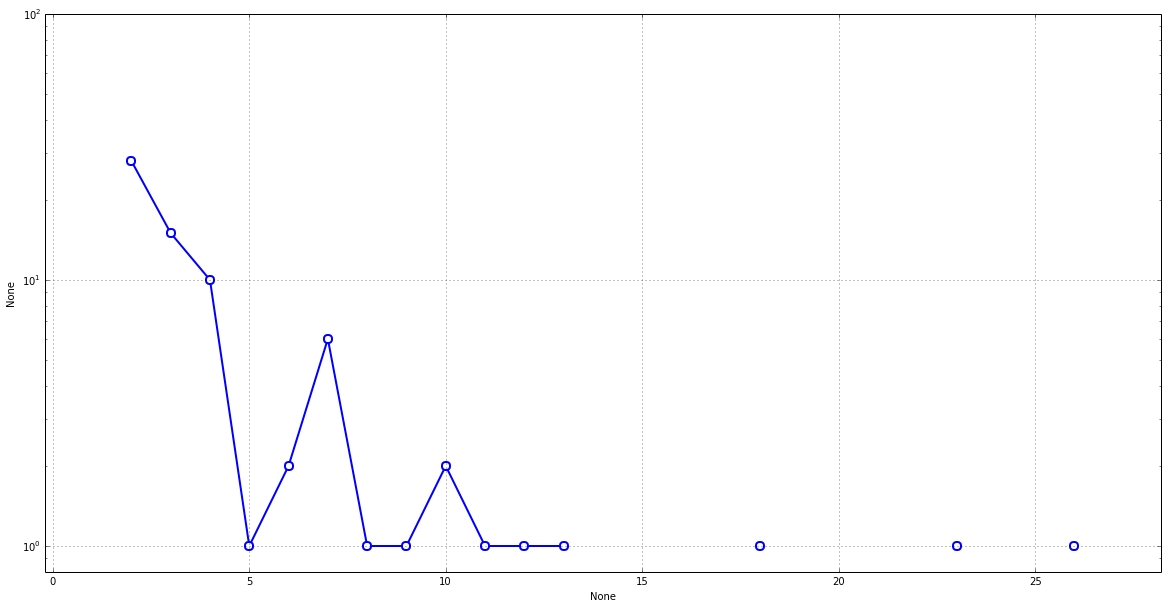

In [49]:
# here we look at some stats.
myutils.draw_grammar_stats(sampler.local_substitutable_graph_grammar.grammar, size=(20,10))

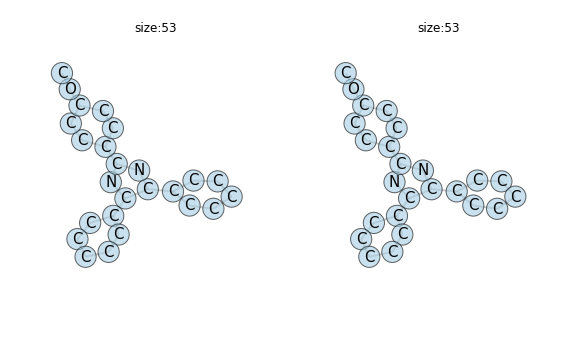

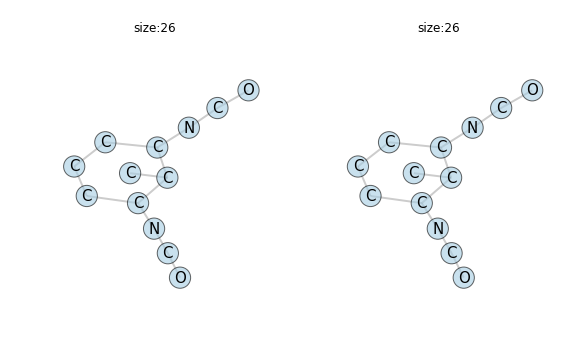

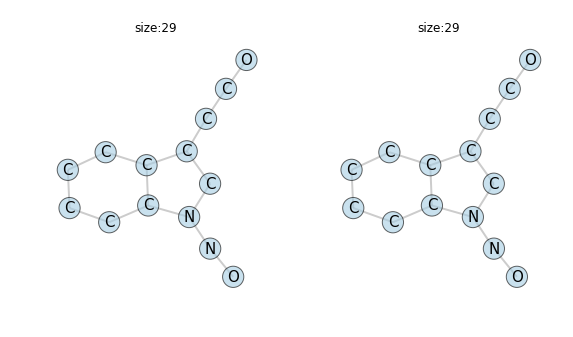

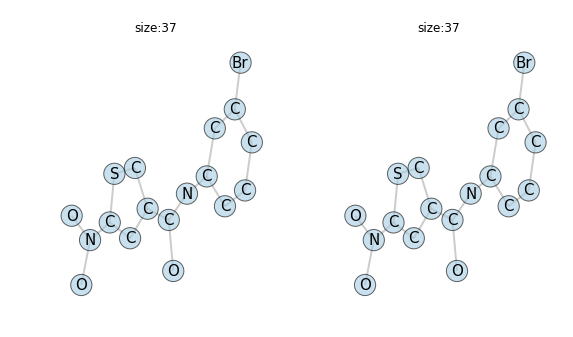

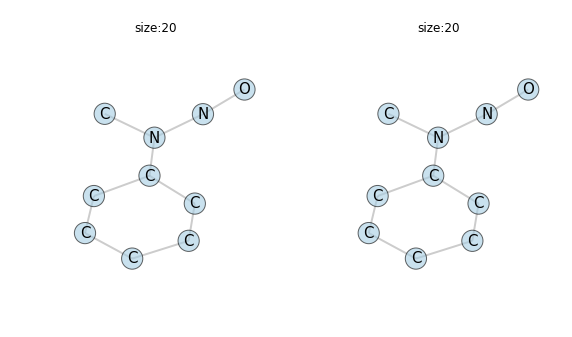

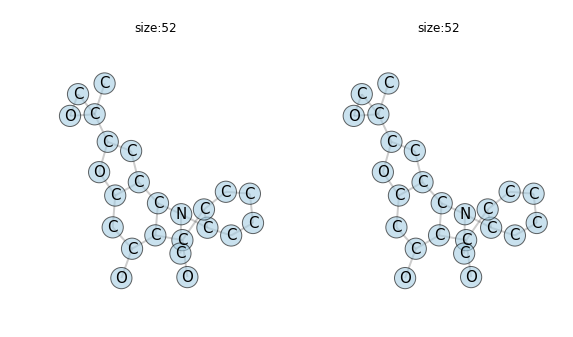

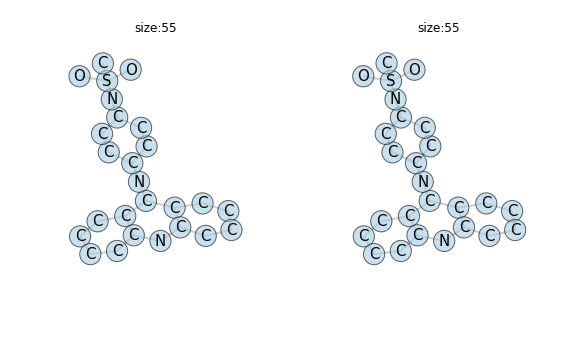

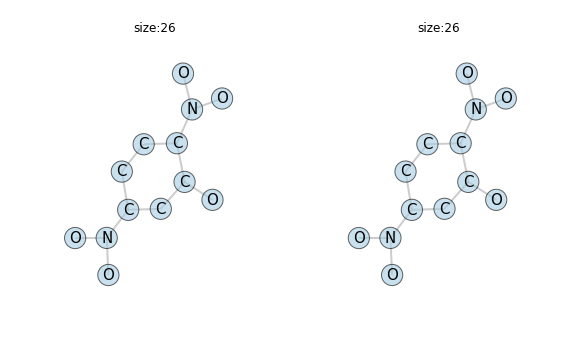

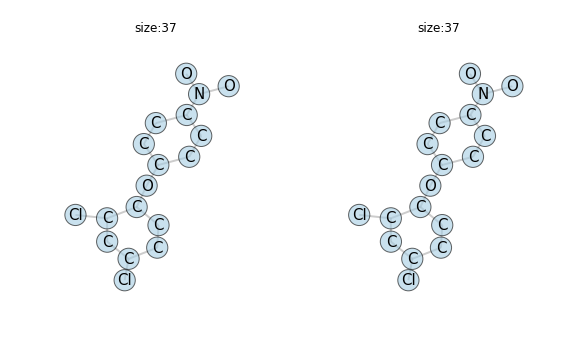

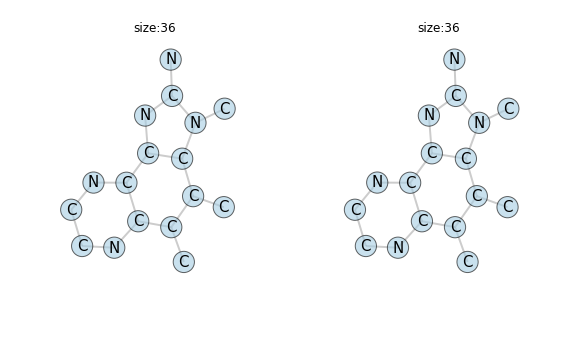

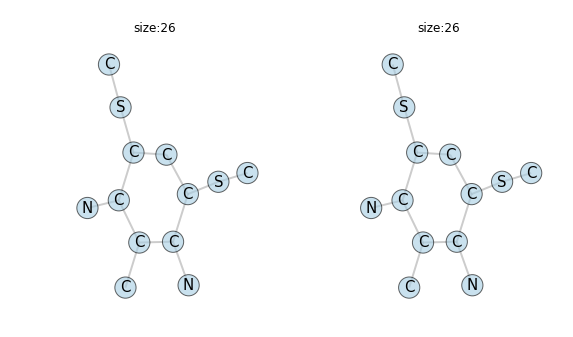

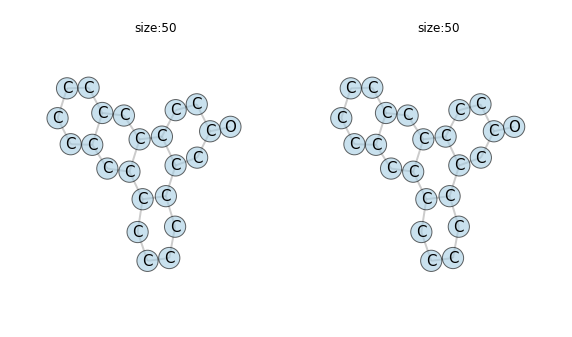

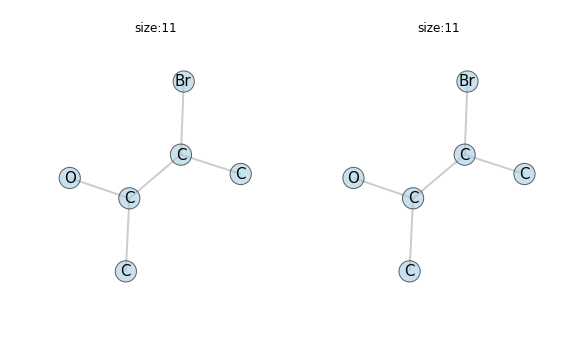

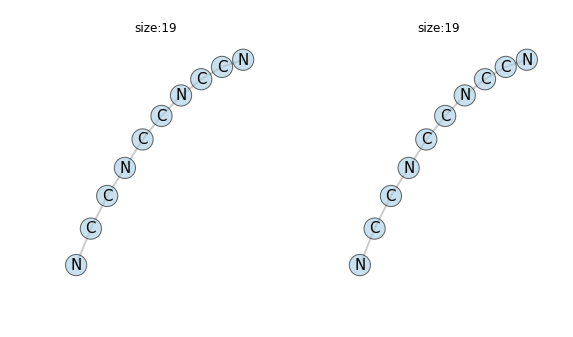

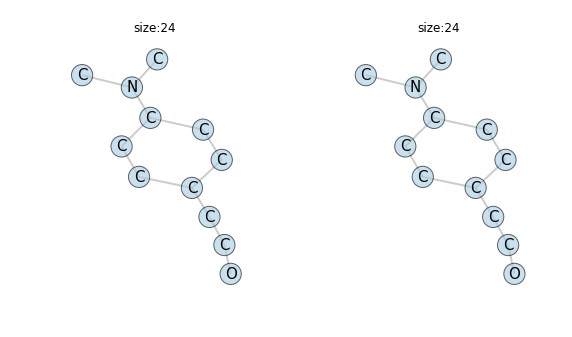

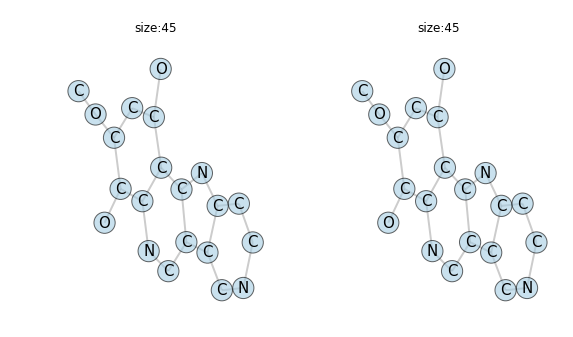

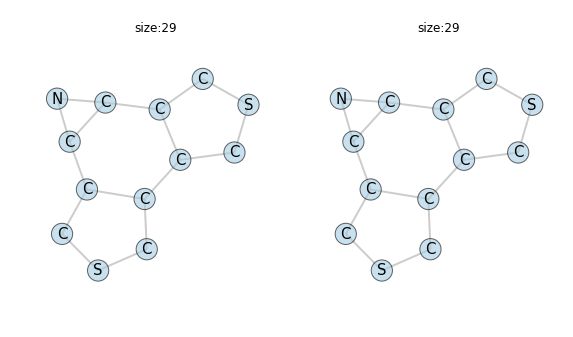

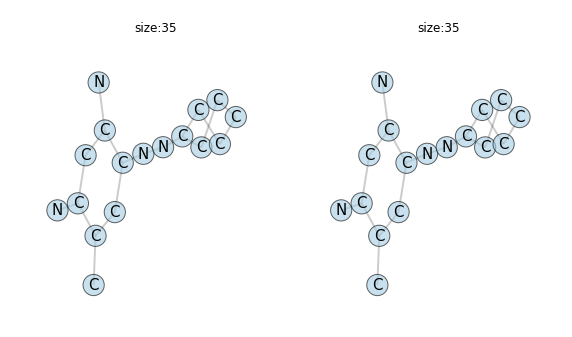

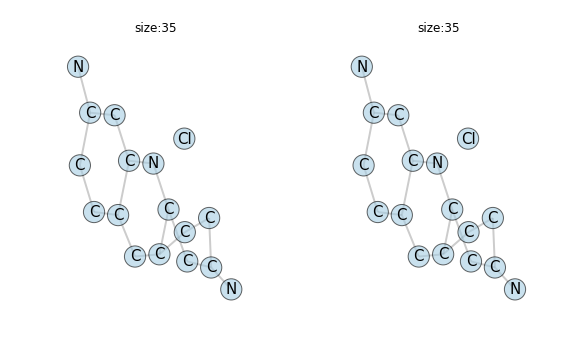

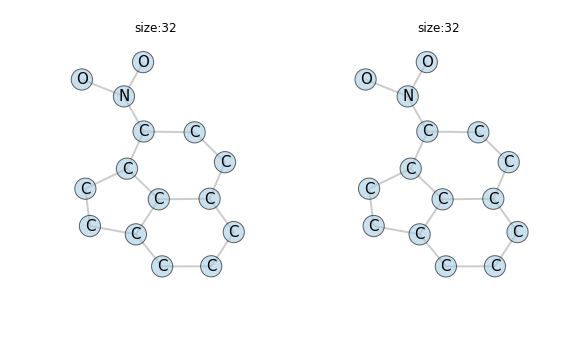

CPU times: user 11.2 s, sys: 1.66 s, total: 12.9 s
Wall time: 14.5 s


In [50]:
%%time
'''
now lets see if we can improve graphs
'''
import sys
sys.path.append('..')
import os
os.nice(19)
%matplotlib inline
import graphlearn.utils.draw as myutils
import graphlearn.graphlearn as gl
from eden.converter.graph.gspan import gspan_to_eden
import itertools
import matplotlib.pyplot as plt


n_steps=140
n_graphs_per_line=10
sampling_interval=int(n_steps/(n_graphs_per_line))
sampling_interval=2

#sampler=gl.GraphLearnSampler()
#sampler.load('tmp/demo.ge')
#print "loading done"
graphs = gspan_to_eden( 'bursi.pos.gspan' )
graphs = itertools.islice(graphs,20)
graphs = sampler.sample(graphs,
                        same_radius=False,
                        same_core_size=True,
                        sampling_interval=sampling_interval,
                        batch_size=1,
                        n_steps=n_steps-sampling_interval,
                        n_jobs=-1,
                        annealing_factor=1.5)

history=[]

for  i, (result,info) in enumerate(graphs):
    history.append(info['score_history'])
    myutils.draw_graph_set(info['graphs'], 
                           n_graphs_per_line=n_graphs_per_line, size=5, 
                           colormap='Paired', invert_colormap=False,node_border=1,
                           vertex_alpha=0.6, edge_alpha=0.2, node_size=450)

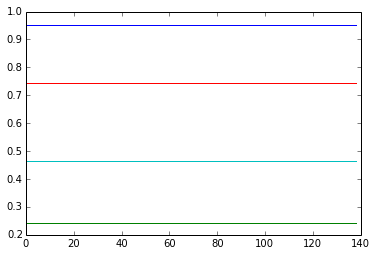

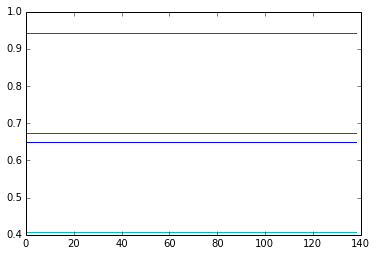

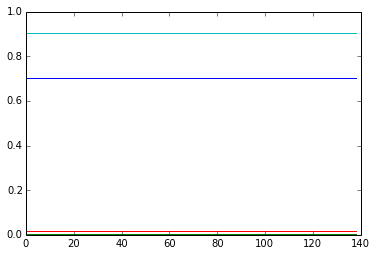

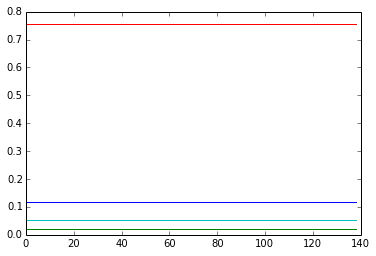

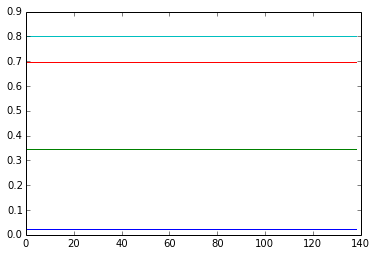

In [51]:
n_per_plot=4
n_plots=len(history)/n_per_plot
for i in range(n_plots):
    for h in history[i*n_per_plot:(i+1)*n_per_plot]:
        plt.plot(h)
    plt.show()